# SberDevices Data Science IDP, задача по извлечению сущностей

## Задача извлечения именованных сущностей (NER)

В задании предлагается написать решение по извлечению именованных сущностей из документов. Интересующие сущности:

- `PER` — персоналии  
- `ORG` — организации  
- `LOC` — локации  
- `EVT` — события  
- `PRO` — продукты  

В стеке NLP такая задача называется Named Entity Recognition (NER). Поскольку доступен размеченный датасет, задача сводится к задаче классификации токенов.

NER-подходу около 30 лет. Впервые термин named entity появился на шестой конференции Message Understanding Conference (MUC-6) в 1995 году.\
Распознавание именованных сущностей было введено как этап подготовки данных для построения событийных шаблонов.

Подход оценивался по метрикам:
- точность (precision),
- полнота (recall),
- F-мера (F1-score),

Он показал высокие результаты (в среднем F-мера ≥ 0.9) и быстро обрёл популярность.

Обзорная статья с метриками и концепцией NER, представленной на MUC-6:  
[https://aclanthology.org/M95-1002.pdf](https://aclanthology.org/M95-1002.pdf)

---

## Классические подходы решения задачи NER

С развитием NLP и в целом технологий менялся и подход к извлечению сущностей.  
Первым подходом, который в том числе использовался для извлечения сущностей во времена MUC6 – это Rule-based подход.  
Он строится на использовании:

- регулярных выражений,  
- лингвистических шаблонов,  
- POS-теггинга  
- и контекстуальных правилах.  

Несмотря на простоту идеи, такой подход требует много ручной работы и плохо масштабируется.


Более продвинутый и популярный подход — на основе скрытых марковских моделей (HMM), в частности CRF,\
которая дополняет идеи марковских моделей и позволяет учитывать контекст с помощью графов вероятностного\
распределения.

С появлением LSTM, стало возможным учитывать контекст без построения графов и по всей последовательности.  
В основе таких подходов лежит двунаправленная BiLSTM, которая миксуется с другими технологиями, например:

- BiLSTM + CRF  
- BiLSTM + CharCNN


После выхода статьи Attention is All You Need популярность обрели трансформерные архитектуры, позволяющие\
ещё лучше определять зависимость между токенами. В рамках задачи NER лучшие результаты показали архитектуры BERT.


Визуализация развития SOTA архитектур для решения задачи NER на датасете Ontonotes v5.

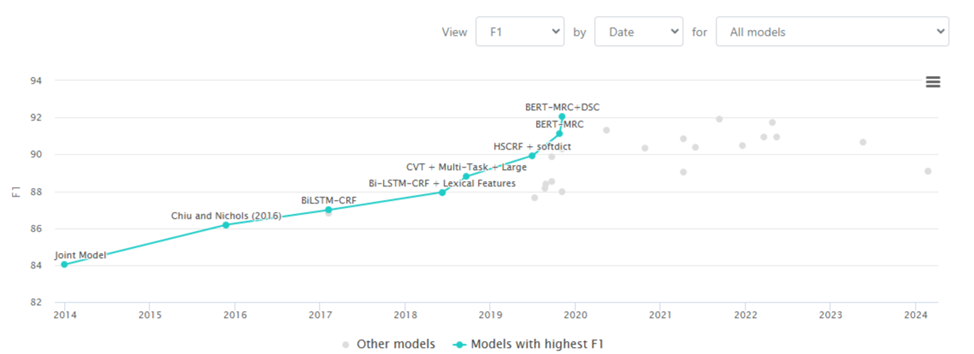

Ссылка на интерактивную визуализацию и детальную информацию:\
[https://paperswithcode.com/sota/named-entity-recognition-ner-on-ontonotes-v5](https://paperswithcode.com/sota/named-entity-recognition-ner-on-ontonotes-v5)


---
## Подход к решению задачи NER с помощью LLM

С появлением мощных языковых моделей, таких как GPT-3, они начали успешно решать даже самые сложные задачи.

В частности для решения задачи NER большие языковые модели имеют ряд преимуществ:

- Задачу разметки сущностей можно решить вручную или с помощью краудсорсинга, однако такие методы требуют\
  значительных временных и финансовых затрат. В то же время, использование LLM позволяет значительно\
  сократить эти расходы, выполняя разметку в десятки раз дешевле.

- Нет необходимости разрабатывать и обучать сложные модели с нуля, затрачивая ресурсы на обучение и поддержание моделей.\
  Почти все крупные LLM предоставляют доступ через API, что позволяет дешево и быстро разметить данные.

- При правильном составлении промптов LLM размечают данные на уровне среднего разметчика с краудсорсинга.


У GigaChat тоже есть API с количеством бесплатных токенов: https://developers.sber.ru/help/gigachat-api

Однако в рамках данной задачи нужно разметить всего 9 документов, поэтому размечать буду через веб-интерфейс.

---
## Метрики для задачи NER

Мной будут использоваться классические метрики для задачи NER, которые использовались в описании задачи\
на MUC6 и используются сейчас для оценки SOTA архитектур. Таким образом можно будет сравнить подход к \
разметке NER с помощью LLM c классическими подходами.

Метрика Precision позволяет оценить как точно модель определяет сущность. То есть сколько из извлеченных сущностей были\
извлечены верно:

$\text{Precision} = \frac{TP}{TP + FP}$

Метрика Recall определяет насколько хорошо модель находит все нужные сущности:

$\text{Recall} = \frac{TP}{TP + FN}$

F1-score, гармоническое среднее Precision и Recall, позволяется учитывать полноту и точность с одинаковой чувствительностью:


$\text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$


# Задача 2. Отбор файлов и формирование датафрейма.

In [489]:
from typing import List, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [490]:
ANNOTATED_FILES_DIR = 'data/training_pl_cs_ru_bg_rc1/annotated/ru'
RAW_FILES_DIR = 'data/training_pl_cs_ru_bg_rc1/raw/ru'

NAMED_ENTITIES_LABELS = ['PER', 'ORG', 'LOC', 'EVT', 'PRO']

EXCLUDE_ARTICLE = 'brexit_ru.txt_file_1162'

**Отбор файлов для анализа**

В данном блоке будет сформирован датафрейм для дальнейшей разметки и анализа.
Предлагалось выбрать для работы 9 файлов из 178 доступных в наборе данных. 

**Логика отбора**

Для того, чтобы на этапах анализа (задания 6-8) получить репрезентативные результаты и не потерять информацию о сущностях, перед формированием датасета мне показалось важным отобрать файлы по следующей логике:

1. Короткие тексты: 3 файла с короткими текстами.
2. Средняя длина текста: 3 файла, длина которых находится в пределах стандартного отклонения.
3. Длинные тексты: 3 файла с длинными текстами.

Также было важно обратить внимание на распределение сущностей внутри файлов. Приоритет отдавался выборкам с максимально неоднородным распределением сущностей, чтобы повысить вероятность того, что в каждом файле представлены все метки и сделать ее более информативной.

**Оценка однородности**

Для замера однородности использовался критерий информативности Джини:

$Gini = 1 - \sum_{i=1}^{n} p_i^2$


где:

- $p_i$ — доля каждой сущности в выборке,
- $n$ — количество сущностей


## Отбор файлов

Вспомогательные функции.

In [491]:
def extract_entities(file_content: str) -> List[str]:
    """
    Извлекает именованные сущности из документа.

    :param file_content: строка содержимого файла
    :return: список именованных сущностей
    """
    return file_content.strip().split("\t")[2::3]

In [492]:
def cut_file_name_tag(file_name: str, file_format: str) -> str:
    """
    Приводит название файла к единому виду для удобства использования.

    :param file_name: название файла
    :param file_format: формат файла

    :return: название файла без формата
    """
    file_format_pos = len(file_name) - len(file_format)
    new_file_name = file_name[:file_format_pos]

    return new_file_name

Функции для подсчета длин и распределений сущностей по файлам для дальнейшего отбора.

In [493]:
def count_gini(probas: pd.Series) -> float:
    """
    Считает критерий Gini, как метрику однородности выборки.
    Чем однороднее выборка, тем менее она информативна.

    :param probas: распределение сущностей
    :return: значение критерия Gini для строки
    """
    probas = np.array(probas)
    probas = probas[probas > 0]

    return 1 - np.sum(probas**2)

In [494]:
def calculate_named_entities_probas(
    entities: List[str],
    named_entities_labels: List[str]
) -> Dict[str, int]:

    """
    Рассчитывает распределение меток
    именованных сущностей по документу.

    :param entities: список сущностей
    :return: словарь с отношением каждой метки
    """
    named_entities_probas = {
        label: 0
        for label in named_entities_labels
    }

    total_entities = len(entities)

    for label in named_entities_labels:
        if total_entities > 0:
            named_entities_probas[label] = (
                entities.count(label) / total_entities
            )
        else:
            named_entities_probas[label] = 0

    return named_entities_probas

In [495]:
def get_entity_stats_dataframe(
    annotated_files_dir: str,
    named_entities_labels: List[str]
) -> pd.DataFrame:

    """
    Формирует датасет с распределением сущностей
    и критерием информативности в этом распределении.

    :param annotated_files_dir: папка с размеченными файлами
    :param named_entities_labels: список интересующих сущностей

    :return: датафрейм с вычисленной информацией по файлам
    """
    documents_data = []
    annotated_files = [
        file for file in os.listdir(annotated_files_dir) if 'brexit' in file.lower()
    ]

    for file_name in annotated_files:
        file_path = os.path.join(annotated_files_dir, file_name)

        with open(file_path, encoding='utf-8') as file:
            file_content = file.read()
            entities = extract_entities(file_content)

        named_entities_probas = (
            calculate_named_entities_probas(entities, named_entities_labels)
        )

        documents_data.append({
            'file_name': cut_file_name_tag(file_name, '.txt'),
            **named_entities_probas
        })

    labels_ratio_dataframe = pd.DataFrame(documents_data)
    labels_ratio_dataframe['impurity_criteria'] = labels_ratio_dataframe[
        named_entities_labels
    ].apply(count_gini, axis=1)

    return labels_ratio_dataframe

In [496]:
def get_raw_text_lengths(raw_files_dir: str) -> pd.DataFrame:
    """
    Формирует датасет с длинами файлов.

    :param raw_files_dir: папка с неразмеченными файлами
    :return: датафрейм с посчитанными длинами файлов
    """

    raw_files = [
        file for file in os.listdir(raw_files_dir) if 'brexit' in file.lower()
    ]
    file_lens = []

    for file_name in raw_files:
        file_path = os.path.join(raw_files_dir, file_name)

        with open(file_path, encoding='utf-8') as file:
            file_lines = file.readlines()
            file_len = sum(len(line.strip()) for line in file_lines[3:])

        file_lens.append({'file_name': cut_file_name_tag(file_name, '.out'), 'file_len': file_len})

    return pd.DataFrame(file_lens)

Формирование датафрейма с информацией о содержимом в файлах и длинах.

In [497]:
entity_stats_dataframe = get_entity_stats_dataframe(ANNOTATED_FILES_DIR, NAMED_ENTITIES_LABELS)
entity_stats_dataframe.head()

,file_name,PER,ORG,LOC,EVT,PRO,impurity_criteria
0,brexit_ru.txt_file_1011,0.611111,0.166667,0.111111,0.055556,0.055556,0.580247
1,brexit_ru.txt_file_1153,0.214286,0.357143,0.214286,0.214286,0.000000,0.734694
2,brexit_ru.txt_file_1036,0.466667,0.333333,0.133333,0.066667,0.000000,0.648889
3,brexit_ru.txt_file_1106,0.400000,0.200000,0.200000,0.066667,0.133333,0.737778
4,brexit_ru.txt_file_1080,0.458333,0.291667,0.166667,0.041667,0.041667,0.673611


In [498]:
text_lengths_dataframe = get_raw_text_lengths(RAW_FILES_DIR)
text_lengths_dataframe.head()

,file_name,file_len
0,brexit_ru.txt_file_1079,1231
1,brexit_ru.txt_file_1117,809
2,brexit_ru.txt_file_1157,1394
3,brexit_ru.txt_file_1096,1005
4,brexit_ru.txt_file_1010,1483


In [528]:
documents_stats_df = pd.merge(entity_stats_dataframe, text_lengths_dataframe, on='file_name')

In [527]:
documents_stats_df = documents_stats_df[
    documents_stats_df['file_name'] != EXCLUDE_ARTICLE
]
documents_stats_df.head()

,file_name,PER,ORG,LOC,EVT,PRO,impurity_criteria,file_len
0,brexit_ru.txt_file_1011,0.611111,0.166667,0.111111,0.055556,0.055556,0.580247,1770
1,brexit_ru.txt_file_1153,0.214286,0.357143,0.214286,0.214286,0.000000,0.734694,970
2,brexit_ru.txt_file_1036,0.466667,0.333333,0.133333,0.066667,0.000000,0.648889,1076
3,brexit_ru.txt_file_1106,0.400000,0.200000,0.200000,0.066667,0.133333,0.737778,1058
4,brexit_ru.txt_file_1080,0.458333,0.291667,0.166667,0.041667,0.041667,0.673611,1384


На выходе 115 файлов, так как отсеялись статьи не про Брексит и статья, с которой GigaChat не работает, так как она посвящена спроным темам.

In [501]:
documents_stats_df.shape

(115, 8)

In [502]:
documents_stats_df.describe()

,PER,ORG,LOC,EVT,PRO,impurity_criteria,file_len
count,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000
mean,0.422648,0.263102,0.188747,0.087409,0.038094,0.676975,1580.060870
std,0.102478,0.089433,0.088602,0.044053,0.049299,0.053581,1019.222324
min,0.055556,0.062500,0.000000,0.014925,0.000000,0.484375,474.000000
25%,0.366029,0.200000,0.131884,0.057983,0.000000,0.657014,1053.500000
50%,0.423077,0.266667,0.181818,0.071429,0.025641,0.684917,1293.000000
75%,0.477226,0.321290,0.250000,0.112374,0.064583,0.710572,1688.500000
max,0.687500,0.500000,0.454545,0.250000,0.277778,0.758400,6753.000000


Функции для отбора датасета.

In [503]:
def filter_data_frame_by_file_len(
    data_frame: pd.DataFrame,
    range_start: int,
    range_end: int
) -> pd.DataFrame:

    """
    Фильтрует входной датафрейм в заданном
    промежутке длин файлов.

    :param data_frame: исходный датафрейм
    :param range_start: минимальная длина файла
    :param range_end: максиммальная длина файла

    :return: отфильтрованный датафрейм
    """

    filtered_data_frame = data_frame[
        (data_frame['file_len'] >= range_start)
        & (data_frame['file_len'] <= range_end)
    ]

    return filtered_data_frame

In [504]:
def find_top_balanced(
    data_frame: pd.DataFrame,
    criteria_column: str,
    top_count: int
) -> pd.DataFrame:

    """
    Оставляет в датафрейме лучшие строки
    по критерию информативности

    :param data_frame: исходный датафрейм
    :param criteria_column: колонка со значениями критерия
    :param top_count: нужное количество строк

    :return: отфильтрованный датафрейм
    """

    data_frame_len = data_frame.shape[0]
    if top_count > data_frame_len:
        top_count = data_frame_len

    top_df = data_frame.sort_values(
        by=criteria_column,
        ascending=False).head(top_count)

    return top_df

In [505]:
def get_top_best_balanced_from_range(
    data_frame: pd.DataFrame,
    range_start: int,
    range_end: int,
    criteria_column: str,
    top_count: int
) -> pd.DataFrame:

    """
    Формирует датафрейм с наиболее информативными
    файлами.

    :param data_frame: исходный датафрейм
    :param range_start: минимальная длина файла
    :param range_end: максиммальная длина файла
    :param criteria_column: колонка со значениями критерия
    :param top_count: нужное количество строк

    :return: датафрейм с наиболее информативными
    файлами
    """

    ranged_df = filter_data_frame_by_file_len(
        data_frame,
        range_start,
        range_end
    )

    ranged_best_balanced_df = find_top_balanced(
        ranged_df,
        criteria_column,
        top_count
    )

    return ranged_best_balanced_df

Отбор файлов по условиям

In [506]:
short_texts_files = get_top_best_balanced_from_range(
    documents_stats_df,
    0, 800,
    'impurity_criteria',
    3
)

In [507]:
short_texts_files

,file_name,PER,ORG,LOC,EVT,PRO,impurity_criteria,file_len
36,brexit_ru.txt_file_1059,0.375000,0.250000,0.250000,0.125000,0.000000,0.718750,670
67,brexit_ru.txt_file_1033,0.454545,0.181818,0.090909,0.181818,0.090909,0.710744,725
92,brexit_ru.txt_file_1086,0.416667,0.250000,0.250000,0.083333,0.000000,0.694444,790


In [508]:
medium_texts_files = get_top_best_balanced_from_range(
    documents_stats_df,
    1000, 2000,
    'impurity_criteria',
    3
)

In [509]:
medium_texts_files

,file_name,PER,ORG,LOC,EVT,PRO,impurity_criteria,file_len
53,brexit_ru.txt_file_1013,0.320000,0.280000,0.200000,0.120000,0.080000,0.758400,1757
27,brexit_ru.txt_file_116,0.300000,0.150000,0.300000,0.200000,0.050000,0.755000,1244
13,brexit_ru.txt_file_103,0.294118,0.294118,0.235294,0.117647,0.058824,0.754325,1249


In [510]:
large_texts_files = get_top_best_balanced_from_range(
    documents_stats_df,
    2100, 7000,
    'impurity_criteria',
    3
)

In [511]:
large_texts_files

,file_name,PER,ORG,LOC,EVT,PRO,impurity_criteria,file_len
46,brexit_ru.txt_file_1047,0.290323,0.322581,0.258065,0.032258,0.096774,0.734651,2354
66,brexit_ru.txt_file_1045,0.333333,0.250000,0.291667,0.125000,0.000000,0.725694,2218
115,brexit_ru.txt_file_1070,0.352941,0.294118,0.235294,0.029412,0.088235,0.724913,2688


In [512]:
balanced_df = pd.concat([
    short_texts_files,
    medium_texts_files,
    large_texts_files
])

In [513]:
balanced_df

,file_name,PER,ORG,LOC,EVT,PRO,impurity_criteria,file_len
36,brexit_ru.txt_file_1059,0.375000,0.250000,0.250000,0.125000,0.000000,0.718750,670
67,brexit_ru.txt_file_1033,0.454545,0.181818,0.090909,0.181818,0.090909,0.710744,725
92,brexit_ru.txt_file_1086,0.416667,0.250000,0.250000,0.083333,0.000000,0.694444,790
53,brexit_ru.txt_file_1013,0.320000,0.280000,0.200000,0.120000,0.080000,0.758400,1757
27,brexit_ru.txt_file_116,0.300000,0.150000,0.300000,0.200000,0.050000,0.755000,1244
13,brexit_ru.txt_file_103,0.294118,0.294118,0.235294,0.117647,0.058824,0.754325,1249
46,brexit_ru.txt_file_1047,0.290323,0.322581,0.258065,0.032258,0.096774,0.734651,2354
66,brexit_ru.txt_file_1045,0.333333,0.250000,0.291667,0.125000,0.000000,0.725694,2218
115,brexit_ru.txt_file_1070,0.352941,0.294118,0.235294,0.029412,0.088235,0.724913,2688


## Формирование датафрейма из выбранных файлов

In [514]:
def extract_text_from_file(file_path: str) -> str:
    """
    Достает из файла текст без служебных строк

    :param file_path: путь до файла
    :return: файл без служебных строк
    """
    with open(file_path , encoding='utf-8') as raw_file:
        file_data = raw_file.readlines()

    return ' '.join(file_data[4:])

In [515]:
def extract_entities_from_file(file_path: str) -> str:
    """
    Извлекает сущности из файла

    :param file_path: путь до файла
    :return: строка с сущностями
    """
    with open(file_path , encoding='utf-8') as annotated_file:
        file_data = annotated_file.readlines()

    entities = [line.split('\t')[2] for line in file_data[1:]]
    return ', '.join(entities)

In [516]:
def form_golden_answers(file_path: str) -> List[str]:
    """
    Приводит данные о размеченных сущностях
    в формат МеткаСущности_ЗначениеСущности

    :param file_path: путь до файла
    :return: строка с размеченными сущностями.
    """
    golden_answers = []

    with open(file_path , encoding='utf-8') as annotated_file:
        file_data = annotated_file.readlines()

    for line in file_data[1:]:
        parts = line.strip().split("\t")

        name = parts[0]
        lemma_name = parts[1]
        entity = parts[2]

        entity_text = lemma_name if lemma_name else name
        entity_label = 'LOC' if entity == 'GPE' else entity

        golden_answers.append(entity_label + '_' + entity_text)

    return ', '.join(golden_answers)

In [517]:
def form_dataframe(
    raw_files_dir: str,
    annotated_files_dir: str,
    file_names: List[str]
) -> pd.DataFrame:

    """
    Формирует датафрейм для работы.
    Колонки: "document_id", "document_text", "entity",
             "gold_answer"

    :param raw_files_dir: путь до сырых данных для
                          получения исходного текста.
    :param annotated_files_dir: путь до размеченных файлов
    :file_names: отобранные для работы файлы

    :return: сформированный датафрейм
    """

    data = []

    for file_name in file_names:
        document_id = file_name.split('_')[-1]

        raw_file_path = (
            os.path.join(raw_files_dir, file_name + '.txt')
        )
        annotated_file_path = (
            os.path.join(annotated_files_dir, file_name + '.out')
        )
        
        document_text = extract_text_from_file(
            raw_file_path
        )

        entity = extract_entities_from_file(
            annotated_file_path
        )

        gold_answer = form_golden_answers(
            annotated_file_path
        )

        data.append({
            "document_id": document_id,
            "document_text": document_text,
            "entity": entity,
            "gold_answer": gold_answer
        })

    return pd.DataFrame(data)

In [526]:
balanced_df_file_names = list(balanced_df['file_name'])
balanced_df_file_names

['brexit_ru.txt_file_1059',
 'brexit_ru.txt_file_1033',
 'brexit_ru.txt_file_1086',
 'brexit_ru.txt_file_1013',
 'brexit_ru.txt_file_116',
 'brexit_ru.txt_file_103',
 'brexit_ru.txt_file_1047',
 'brexit_ru.txt_file_1045',
 'brexit_ru.txt_file_1070']

In [519]:
df = form_dataframe(
    RAW_FILES_DIR,
    ANNOTATED_FILES_DIR,
    balanced_df_file_names
)

df.head()

,document_id,document_text,entity,gold_answer
0,1059,311 26:28 Британский кризис. Время покажет. Вы...,"EVT, PER, PER, LOC, PER, LOC, ORG, ORG","EVT_Brexit, PER_Борис Джонсон, PER_Дэвид Дэвис..."
1,1033,Министром по делам «Брексита» назначен Доминик...,"EVT, EVT, LOC, PER, PER, ORG, ORG, PER, PER, P...","EVT_Брексит, EVT_Брексит, LOC_Великобритания, ..."
2,1086,17:57 Глава МИД Великобритании Борис Джонсон п...,"LOC, EVT, LOC, PER, LOC, PER, PER, PER, ORG, O...","LOC_Хофбург, EVT_Brexit, LOC_Асгардия, PER_Бор..."
3,1013,МИД РФ: Борис Джонсон не захотел оставаться в ...,"EVT, PRO, ORG, PER, PER, LOC, LOC, PER, ORG, P...","EVT_Brexit, PRO_Facebook, ORG_REGNUM, PER_Бори..."
4,116,Советник Трампа тайно встретился с английскими...,"EVT, PRO, LOC, PER, EVT, LOC, PER, PER, ORG, O...","EVT_Brexit, PRO_The Telegraph, LOC_Англия, PER..."


# Задача 3 Составление промпта для LLM

При NER разметке с использованием LLM. Основное внимание нужно уделить промпту.

В представленных файлах также можно выделить политический домен, некоторые \
сущности могут быть специфичными. Например, парламент Великобритании значительно \
выбивается из привычного понимания организации.

Поэтому считаю, что в промпте нужно указать данные особенности.

Также буду использовать классические подходы для повышения качества разметки
- few-shot examples
- chain-of-thoughts

Забирать из ответов модели буду только разметку.

In [520]:
def prepare_prompt(
    data: str,
    main_prompt: str,
    output_format_prompt: str,
    text_start: str = 'ТЕКСТ ДЛЯ РАЗМЕТКИ --> ',
    text_end: str = '<-- КОНЕЦ ТЕКСТА ДЛЯ РАЗМЕТКИ',
    divider: str = '\n',
) -> str:
    """
    Собирает итоговый промпт из составных частей

    :param data: основной текст для разметки
    :param main_prompt: основа промпта с инструкцией
    :param output_format_prompt: инструкция вывода
    :param text_start: метка начала текста для разметки
    :param text_end: метка конца текста для разметки

    :return: собранный промпт
    """
    
    prompt = (
        main_prompt + divider
        + output_format_prompt + divider
        + text_start + data + text_end
    )
    return prompt

In [521]:
main_prompt = '''
Ты — ассистент по лингвистической разметке текста.
Тексты, с которыми ты будешь работать, посвящены политической теме, событию Брексит / Brexit.
Обращай особое внимание на политические термины и организации, такие как партии, правительственные структуры,
политические движения.

ОБЯЗАТЕЛЬНО: каждое вхождение сущности размечается заново, даже если уже встречалось ранее.
- Обращай внимание на английские символы, пример Brexit. Скорее всего это сущность.
- Нельзя объединять сущности: PER_Трамп и PER_Дональд Трамп - это отдельные сущности

Нужно выделить из текста сущности, они могут быть такими:
- EVT (события) — выборы, политические кризисы, важные законодательные акты.
- PER (имена людей) — политические лидеры, представители правительств, партий, другие.
- ORG (названия организаций) — политические партии, государственные учреждения, международные организации.
- LOC (местоположение, страны) — страны, города, регионы, участвующие в политических событиях.
- PRO (продукты компаний) — политические инициативы, интернет площадки, товары.
предложения по законодательным изменениям или национальные проекты.
'''

In [522]:
output_format = '''
Перед выходом выведи цепочку размышлений. Объясни: Почему ты определили токены в сущность -> К какому типу лучше отнести
сущность, смотря на описание типов LOC, PER, ORG, EVT, PRO.

ОБЯЗАТЕЛЬНЫЙ ФОРМАТ ВЫВОДА - список сущностей в строку --> LOC_Лондон, PER_Винстон Черчилль, ORG_Парламент Великобритании, EVT_Брексит, PRO_Teletype.
'''

In [523]:
def make_prompts(
    data: pd.DataFrame,
    main_prompt: str,
    output_format_prompt: str
) -> List[str]:
    """
    Составляет промпты для всех строк
    датафрейма.

    :param data: датафрейм для разметки
    :param main_prompt: основа промпта с инструкцией
    :param output_format_prompt: инструкция вывода
    
    :return: датасет с промптами
    """
    prompts = []

    for document_text in data:
        prompt = prepare_prompt(
            document_text,
            main_prompt,
            output_format_prompt
        )

        prompts.append(prompt)
    
    return prompts

Соберем промпты и выведем пример

In [524]:
dataset_prompts = make_prompts(df['document_text'], main_prompt, output_format)

In [525]:
print(dataset_prompts[0])


Ты — ассистент по лингвистической разметке текста.
Тексты, с которыми ты будешь работать, посвящены политической теме, событию Брексит / Brexit.
Обращай особое внимание на политические термины и организации, такие как партии, правительственные структуры,
политические движения.

ОБЯЗАТЕЛЬНО: каждое вхождение сущности размечается заново, даже если уже встречалось ранее.
- Обращай внимание на английские символы, пример Brexit. Скорее всего это сущность.
- Нельзя объединять сущности: PER_Трамп и PER_Дональд Трамп - это отдельные сущности

Нужно выделить из текста сущности, они могут быть такими:
- EVT (события) — выборы, политические кризисы, важные законодательные акты.
- PER (имена людей) — политические лидеры, представители правительств, партий, другие.
- ORG (названия организаций) — политические партии, государственные учреждения, международные организации.
- LOC (местоположение, страны) — страны, города, регионы, участвующие в политических событиях.
- PRO (продукты компаний) — полити

# Задание 4. Формируем датасет из полученных ответов

Я сохранял разметку GigaChat в текстовый файл. В данном блоке сформируем датасет с размеченными данными.

## Составление датафрейма с разметкой

In [294]:
labeled_data_path = 'gigachat-data/named_entities_gigachat.txt'

with open(labeled_data_path, 'r', encoding='utf-8') as file:
    file_text = file.read()

gigachad_labels = [label.strip() for label in file_text.split('\n\n') if label != '']

df['gigachat_labels'] = gigachad_labels

df.head()

,document_id,document_text,entity,gold_answer,gigachat_labels
0,1059,311 26:28 Британский кризис. Время покажет. Вы...,"EVT, PER, PER, LOC, PER, LOC, ORG, ORG","EVT_Brexit, PER_Борис Джонсон, PER_Дэвид Дэвис...","LOC_Лондон, ORG_правительство Великобритании, ..."
1,1033,Министром по делам «Брексита» назначен Доминик...,"EVT, EVT, LOC, PER, PER, ORG, ORG, PER, PER, P...","EVT_Брексит, EVT_Брексит, LOC_Великобритания, ...","PER_Доминик Рааб, PER_Тереза Мэй, LOC_Великобр..."
2,1086,17:57 Глава МИД Великобритании Борис Джонсон п...,"LOC, EVT, LOC, PER, LOC, PER, PER, PER, ORG, O...","LOC_Хофбург, EVT_Brexit, LOC_Асгардия, PER_Бор...","LOC_Великобритания, PER_Борис Джонсон, PER_Тер..."
3,1013,МИД РФ: Борис Джонсон не захотел оставаться в ...,"EVT, PRO, ORG, PER, PER, LOC, LOC, PER, ORG, P...","EVT_Brexit, PRO_Facebook, ORG_REGNUM, PER_Бори...","LOC_Великобритания, ORG_МИД России, PER_Борис ..."
4,116,Советник Трампа тайно встретился с английскими...,"EVT, PRO, LOC, PER, EVT, LOC, PER, PER, ORG, O...","EVT_Brexit, PRO_The Telegraph, LOC_Англия, PER...","PER_Джон Болтон, PER_Дональд Трамп, ORG_Европе..."


In [ ]:
df.to_csv('gigachat-data/gigachat_labeled.csv', index=False)

## Ответы GigaChat

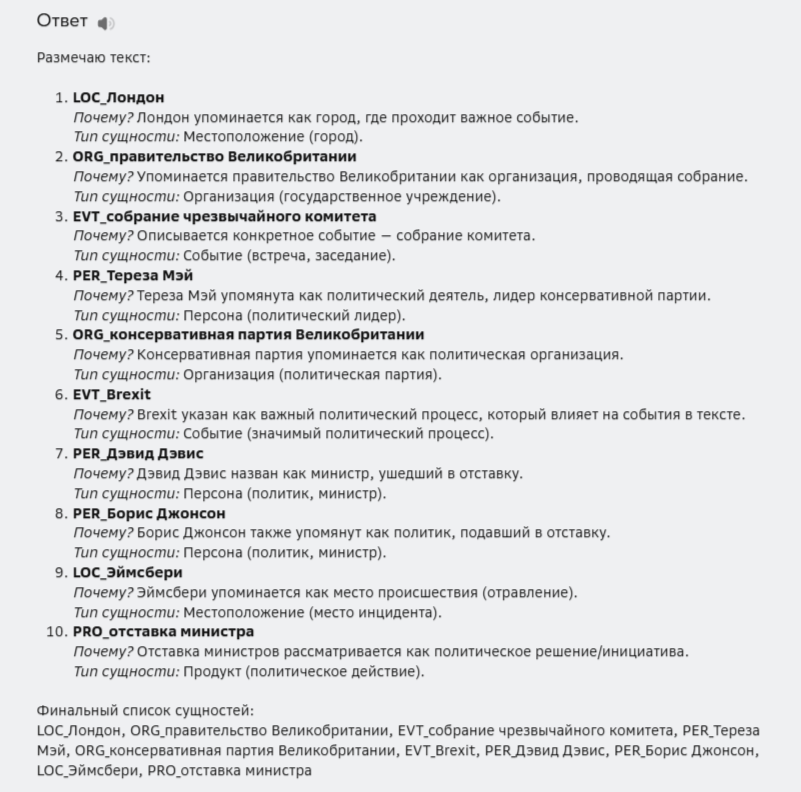

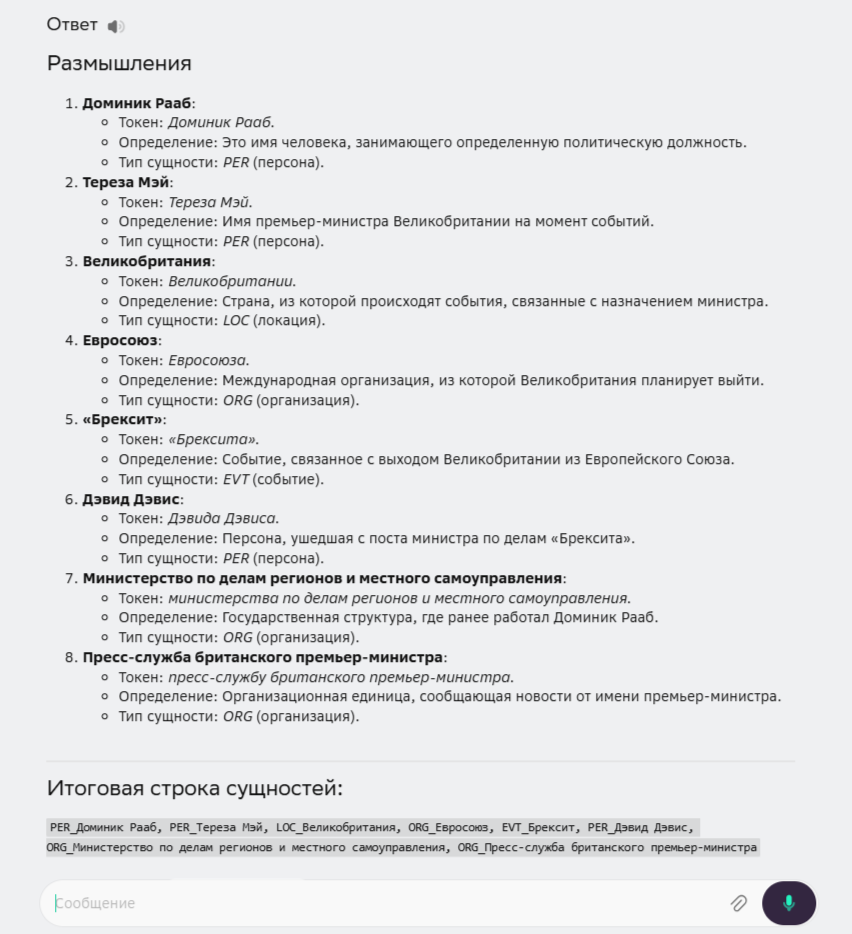

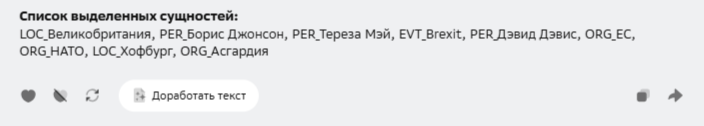

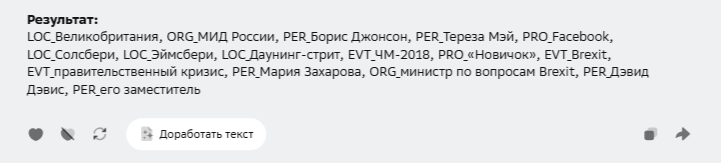

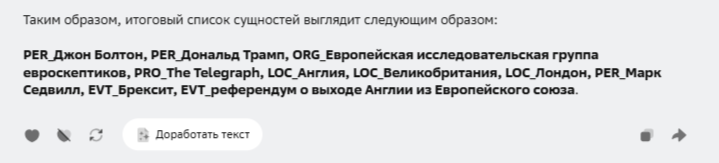

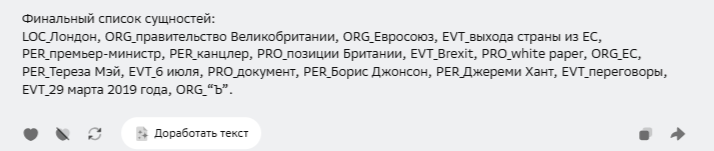

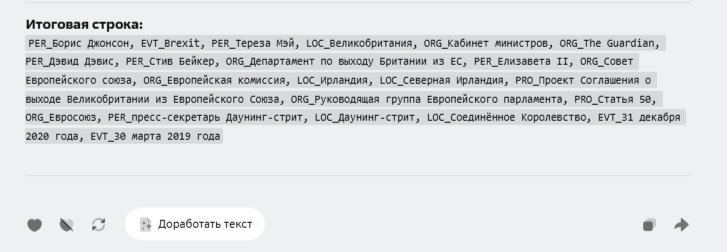

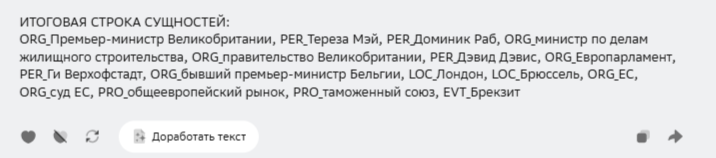

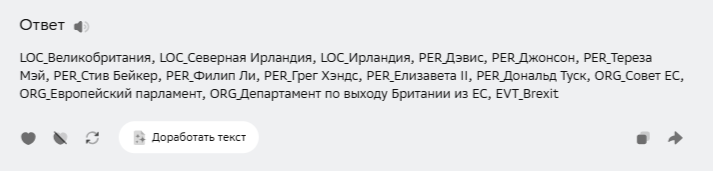

Для автоматизации можно написать несколько методов для обращения к GigaChat API.

# Задание 5. Подсчет метрик

Выбор метрик обусловлен в описании задачи (первый пункт).

### Функции для подсчета метрик

In [296]:
def parse_entities(data: str) -> set:
    """
    Функция извлекает сущности из строки данных.
    в формате {(entity_name, entity)}.

    :param data: строка с сущностями через запятую.
    :return: множество уникальных сущностей
    """
    if not data.strip():
        return set()

    entities = data.split(',')

    return set(tuple(entity.strip().split('_', 1)) for entity in entities)

In [297]:
def score_fn(gold: str, pred: str) -> Tuple[int, int, int]:
    """
    Считает метрики:
    F1-score
    Precision
    Recall

    :param gold: строка с эталонной разметкой
    :param pred: строка с разметкой LLM

    :return: значения метрик
    """
    gold_entities = parse_entities(gold)
    pred_entities = parse_entities(pred)

    tp = len(gold_entities & pred_entities)
    if tp == 0:
        return 0.0, 0.0, 0.0

    fp = len(pred_entities - gold_entities)
    fn = len(gold_entities - pred_entities)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * precision * recall / (precision + recall)

    return f1_score, precision, recall

In [298]:
def count_metrics(data: pd.DataFrame, agg_by: str = 'doc') -> pd.DataFrame:
    """
    Считает метрики по всему датасету:
    F1-score
    Precision
    Recall

    Датасет может быть агрегирован:
    doc - по документу
    ne - по сущности (LOC, PRO и другие)

    :param data: датасет с разметкой
    :param agg_by: параметр агрегации
    """
    metrics = []

    for _, row in data.iterrows():
        metric = {}

        if agg_by == 'doc':
            metric['document_id'] = row['document_id']
            metric['document_len'] = len(str(row['document_text']))

        elif agg_by == 'ne':
            metric['named_entity'] = row['named_entity']

        gold = row['gold_answer']
        pred = row['gigachat_labels']

        f1_score, precision, recall = score_fn(gold, pred)
        metric['f1_score'] = f1_score
        metric['precision'] = precision
        metric['recall'] = recall

        metrics.append(metric)

    return pd.DataFrame(metrics)

### Описание тестов

Для подсчета метрик использовалась функция score_fn и вспомогательная функция parse_entities.\
На них написаны юнит-тесты, хранящиеся в папке репозитория tests

Для запуска тестов из корневой директории репозитория:

```bash
python -m unittest discover -s tests
```

В тестах описаны следующие случаи

Для функции score_fn:

- Тест на полное совпадение.
- Тест на совпадение половины сущностей.
- Тест на частичное совпадение сущностей.
- Тест, при котором Precision > Recall.
- Тест на нулевое совпадение.
- Тест-кейс LLM перепредсказала сущности.
- Тест-кейс LLM не выделила сущности.
- Тест-кейс с пустой разметкой.

Для функции parse_entities:

- Тест с пустой строкой.
- Тест со строкой из пробелов.
- Тест с несколькими сущностями.
- Тест с дубликатами.
- Тест с сущностью из нескольких слов.
- Тест с разделителем "_" внутри сущности.


Подробнее можно посмотреть в папке /tests Функции справились со всеми тестами.

# Задание 6. Вычисление метрик и агрегация по типам сущностей

В этом блоке будет выполнена агрегация разметки по типам сущностей, расчет метрик с использованием функций из блока 5, а также их визуализация как по сущностям, так и по документам. В завершение будут представлены выводы, основанные на полученных визуализациях.

## Агрегация по типам сущностей

In [299]:
def aggregate_by_entity(
    data: pd.DataFrame,
    entities_list: List[str] = NAMED_ENTITIES_LABELS
) -> pd.DataFrame:
    """
    Принимает датафрейм, объединенный по документам,
    и объединяет все метки по типам сущностей.

    :param data: датафрейм, объединенный по документам.
    :param entities_list: список всех типов сущностей.

    :return: датафрейм, объединенный по типам сущностей.
    """

    agg_by_entities = {
        entity: {'gold_answer': '', 'gigachat_labels': ''}
        for entity in entities_list
    }

    for _, row in data.iterrows():
        gold_entities = row['gold_answer'].split(', ')
        pred_entities = row['gigachat_labels'].split(', ')

        for entity in entities_list:
            entity_golds = [
                ent for ent in gold_entities
                if ent.startswith(f'{entity}_')
            ]
            entity_labels = [
                ent for ent in pred_entities
                if ent.startswith(f'{entity}_')
            ]

            agg_by_entities[entity]['gold_answer'] += (
                ', '.join(entity_golds) + ', '
                if entity_golds else ''
            )
            agg_by_entities[entity]['gigachat_labels'] += (
                ', '.join(entity_labels) + ', '
                if entity_labels else ''
            )

    for entity in entities_list:
        agg_by_entities[entity]['gold_answer'] = (
            agg_by_entities[entity]['gold_answer'].strip(', ')
        )
        agg_by_entities[entity]['gigachat_labels'] = (
            agg_by_entities[entity]['gigachat_labels'].strip(', ')
        )

    agg_df = pd.DataFrame.from_dict(
        agg_by_entities, orient='index'
    ).reset_index().rename(columns={'index': 'named_entity'})

    return agg_df

In [300]:
ne_aggregated_df = aggregate_by_entity(df)
ne_aggregated_df.head()

,named_entity,gold_answer,gigachat_labels
0,PER,"PER_Борис Джонсон, PER_Дэвид Дэвис, PER_Тереза...","PER_Тереза Мэй, PER_Дэвид Дэвис, PER_Борис Джо..."
1,ORG,"ORG_консервативная партия Великобритании, ORG_...","ORG_правительство Великобритании, ORG_консерва..."
2,LOC,"LOC_Лондон, LOC_Эймсбери, LOC_Великобритания, ...","LOC_Лондон, LOC_Эймсбери, LOC_Великобритания, ..."
3,EVT,"EVT_Brexit, EVT_Брексит, EVT_Брексит, EVT_Brex...","EVT_собрание чрезвычайного комитета, EVT_Brexi..."
4,PRO,"PRO_Ъ, PRO_Facebook, PRO_Новичок, PRO_The Tele...","PRO_отставка министра, PRO_Facebook, PRO_«Нови..."


## Подсчет метрик

In [301]:
documents_metrics_df = count_metrics(df).sort_values(by='document_len', ascending=True)
documents_metrics_df.head()

,document_id,document_len,f1_score,precision,recall
0,1059,572,0.888889,0.800000,1.000000
1,1033,697,0.666667,0.750000,0.600000
2,1086,761,0.761905,0.888889,0.666667
4,116,1174,0.571429,0.800000,0.444444
5,103,1221,0.470588,0.444444,0.500000


In [302]:
ne_metrics_df = count_metrics(
    ne_aggregated_df, agg_by='ne'
).sort_values(by='f1_score', ascending=False)

ne_metrics_df.head()

,named_entity,f1_score,precision,recall
2,LOC,0.709677,1.000000,0.550000
0,PER,0.708333,0.772727,0.653846
1,ORG,0.549020,0.560000,0.538462
3,EVT,0.363636,0.307692,0.444444
4,PRO,0.200000,0.181818,0.222222


## Визуализации

### Метрики в группировке по именованным сущностям

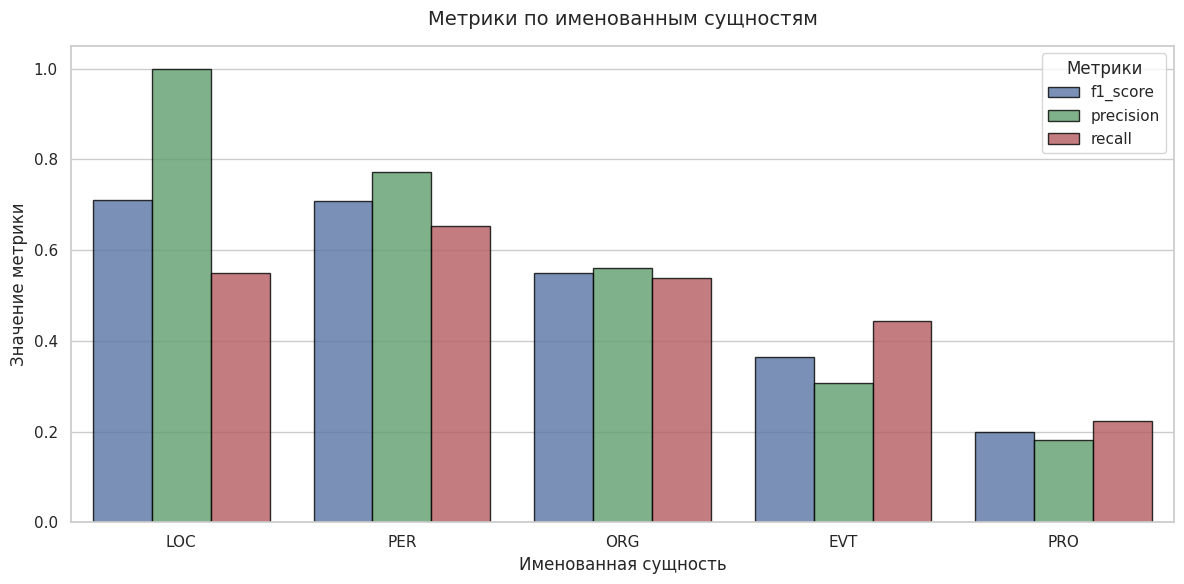

In [303]:
plt.figure(figsize=(12, 6))

sns.barplot(
    data=ne_metrics_df.melt(
        id_vars='named_entity',
        var_name='metric',
        value_name='score'
    ),
    x='named_entity',
    y='score',
    hue='metric',
    palette=['b', 'g', 'r'],
    alpha=0.8,
    edgecolor='black',
    linewidth=1
)

plt.title('Метрики по именованным сущностям', fontsize=14, pad=15)
plt.xlabel('Именованная сущность', fontsize=12)
plt.ylabel('Значение метрики', fontsize=12)
plt.ylim(0, 1.05)

plt.legend(title='Метрики', loc='upper right')
plt.tight_layout()
plt.show()

### Метрики в группировке по документам

In [304]:
documents_metrics_df_fpr = documents_metrics_df[
    ['document_id', 'f1_score', 'precision', 'recall']
]

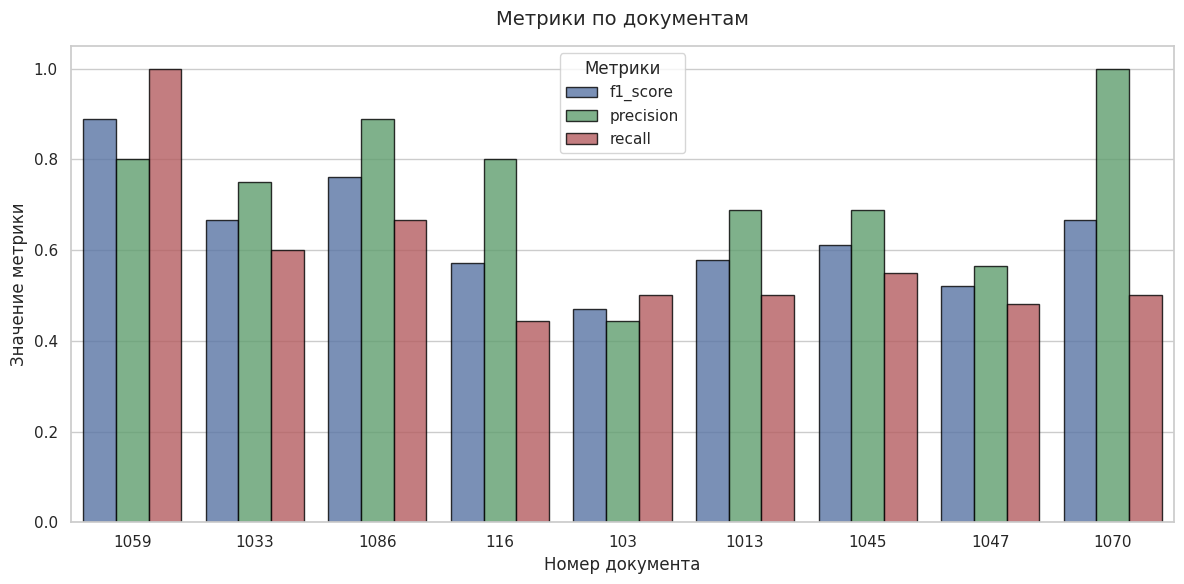

In [305]:
plt.figure(figsize=(12, 6))

sns.barplot(
    data=documents_metrics_df_fpr.melt(
        id_vars='document_id',
        var_name='metric',
        value_name='score'
    ),
    x='document_id',
    y='score',
    hue='metric',
    palette=['b', 'g', 'r'],
    alpha=0.8,
    edgecolor='black',
    linewidth=1
)

plt.title('Метрики по документам', fontsize=14, pad=15)
plt.xlabel('Номер документа', fontsize=12)
plt.ylabel('Значение метрики', fontsize=12)
plt.ylim(0, 1.05)

plt.legend(title='Метрики', loc='upper center')
plt.tight_layout()
plt.show()

### Баланс сущностей в выборках

Вспомогательная визуализация, чтобы учитывать баланс представленных сущностей в выводах.

In [306]:
gold_answer_count = list(ne_aggregated_df['gold_answer'].str.split(',').apply(len))
gigachat_answer_count = list(ne_aggregated_df['gigachat_labels'].str.split(',').apply(len))
print(gold_answer_count, gigachat_answer_count)

[61, 48, 44, 18, 11] [40, 32, 23, 19, 11]


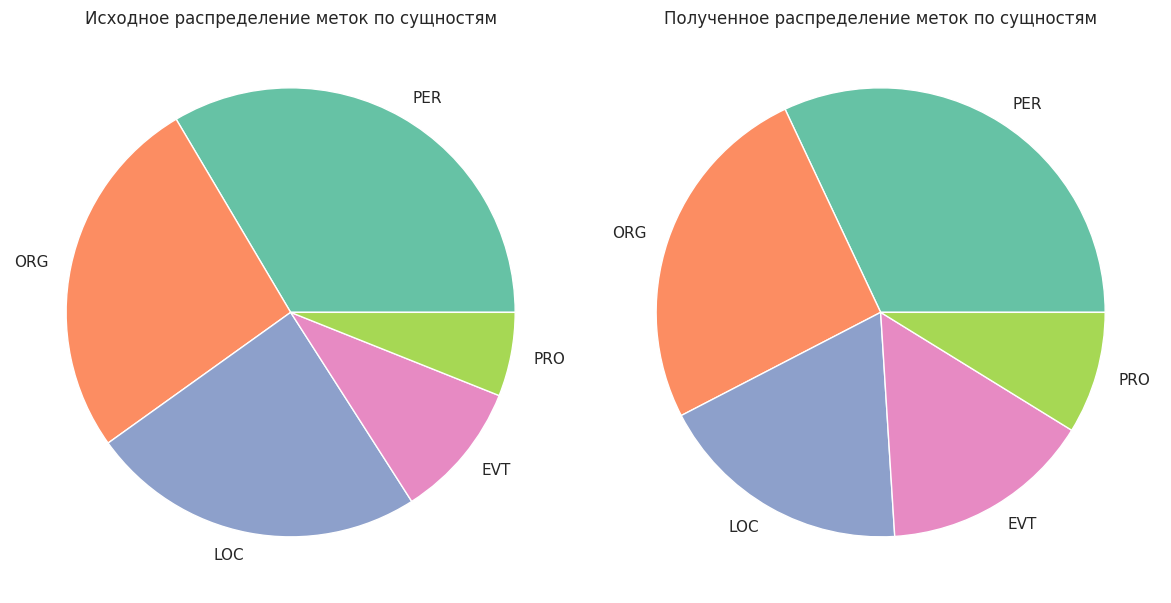

In [307]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].pie(
    gold_answer_count,
    labels=NAMED_ENTITIES_LABELS,
    colors=sns.color_palette("Set2", len(gold_answer_count))
)
axes[0].set_title('Исходное распределение меток по сущностям')

axes[1].pie(
    gigachat_answer_count,
    labels=NAMED_ENTITIES_LABELS,
    colors=sns.color_palette("Set2", len(gigachat_answer_count))
)
axes[1].set_title('Полученное распределение меток по сущностям')

plt.tight_layout()
plt.show()

## Выводы

Часто разметка точно попадает в сущности, однако основная проблема заключается в том, что она недоразмечает нужные сущности.

Как по круговой визуализации, так и по Precision, видно, что в сущности EVT и PRO часто попадают не те объекты.

Показатели на сущностях LOC и PER значительно лучше, чем на ORG, EVT и PRO. В случае с EVT и PRO это может быть связано с тем, что таких сущностей внутри выборки меньше.

Метка ORG представлена в достаточной степени, но возможно стоит более тщательно проанализировать её и дать модели дополнительные подсказки в сложных ситуациях.


# Задание 7. Зависимость метрик от длины документа

Наиболее удобным графиком для отображения будет линейный, в котором по оси y будет отображаться скор
метрики, а по оси x длина документов в отсортированном порядке.

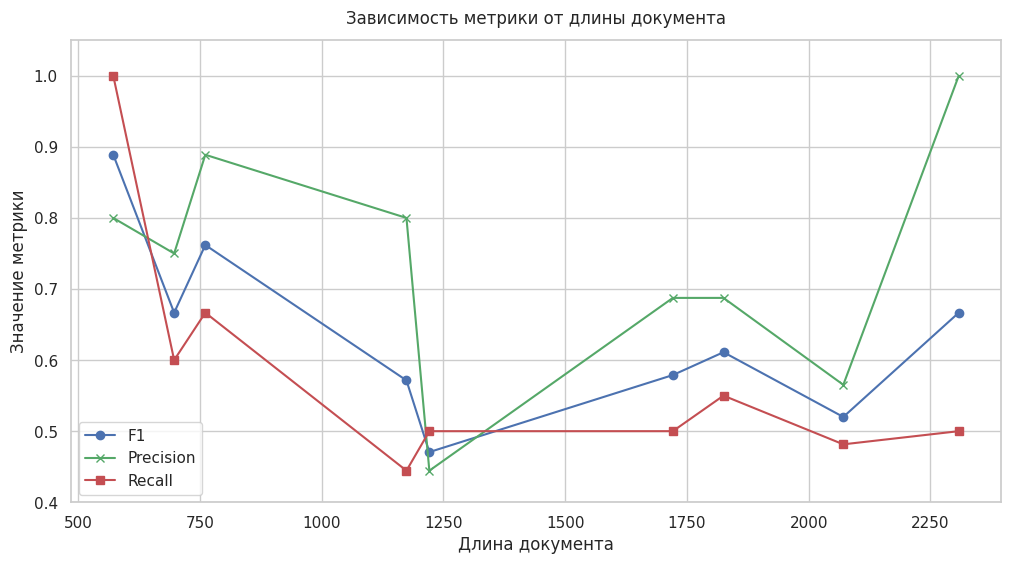

In [309]:
plt.figure(figsize=(12, 6))

plt.plot(
    documents_metrics_df['document_len'],
    documents_metrics_df['f1_score'],
    marker='o', color='b', 
    label='F1'
)
plt.plot(
    documents_metrics_df['document_len'],
    documents_metrics_df['precision'],
    marker='x', color='g',
    label='Precision'
)
plt.plot(
    documents_metrics_df['document_len'],
    documents_metrics_df['recall'],
    marker='s', color='r',
    label='Recall'
)

plt.title('Зависимость метрики от длины документа', pad=12)
plt.xlabel('Длина документа')
plt.ylabel('Значение метрики')
plt.ylim(0.4, 1.05)

plt.legend(loc='lower left')

plt.show()

### Выводы

Лучшие показатели у коротких документов

Recall резко снижается с ростом длины документа. Это означает, что моделям сложно находить все сущности на длинных документах.

Можно сделать вывод, что эффективнее будет разбивать длинные документы на более короткие части и подавать их в промпт в таком виде.


# Задание 8. Анализ ошибок

В данном блоке проанализируем ошибки. Конкретнее FalsePositive и FalseNegative, ошибку первого и второго рода. На основе анализа можно будет сделать выводы и составить план действий для снижения ошибок.

### Получение информации об ошибках

In [329]:
def get_confusion_components(row: pd.Series) -> pd.Series:
    """
    Считает показатели:
    True Positive
    False Positive
    False Negative

    :param row: ряд данных, для которых считаем показатель.
    :return: ряд с рассчитанными показателями.
    """
    gold_entities = parse_entities(row['gold_answer'])
    pred_entities = parse_entities(row['gigachat_labels'])

    tp = len(gold_entities & pred_entities)
    fp = len(pred_entities - gold_entities)
    fn = len(gold_entities - pred_entities)

    return pd.Series({'tp': tp, 'fp': fp, 'fn': fn})

In [334]:
def form_confusion_df(data: pd.DataFrame, agg_by: str = 'doc') -> pd.DataFrame:
    """
    Формирует датафрейм с посчитанными показателями:
    True Positive
    False Positive
    False Negative

    :param data: датафрейм, для которго считаем показатели
    :param agg_by: по какому признаку агрегирован датафрейм
                   по документу или по типу сущности

    :return: датафрейм с посчитанными показателями
    """
    confusion_df = pd.DataFrame()

    if agg_by == 'doc':
        confusion_df['document_id'] = data['document_id'].copy()
    if agg_by == 'ne':
        confusion_df['named_entity'] = data['named_entity'].copy()

    confusion_df[['tp', 'fp', 'fn']] = data.apply(get_confusion_components, axis=1)

    return confusion_df

In [331]:
ne_confusion_df = form_confusion_df(ne_aggregated_df, agg_by='ne')
ne_confusion_df.head()

,named_entity,tp,fp,fn
0,PER,17,5,9
1,ORG,14,11,12
2,LOC,11,0,9
3,EVT,4,9,5
4,PRO,2,9,7


In [347]:
document_confusion_df = form_confusion_df(df)

document_confusion_df.head()

,document_id,tp,fp,fn
0,1059,8,2,0
1,1033,6,2,4
2,1086,8,1,4
3,1013,11,5,11
4,116,8,2,10


## Визуализации

Визуализации с предыдущих шагов также будут полезны для анализа ошибок.

### Ошибки и показатель True Positive в группировке по именованным сущностям

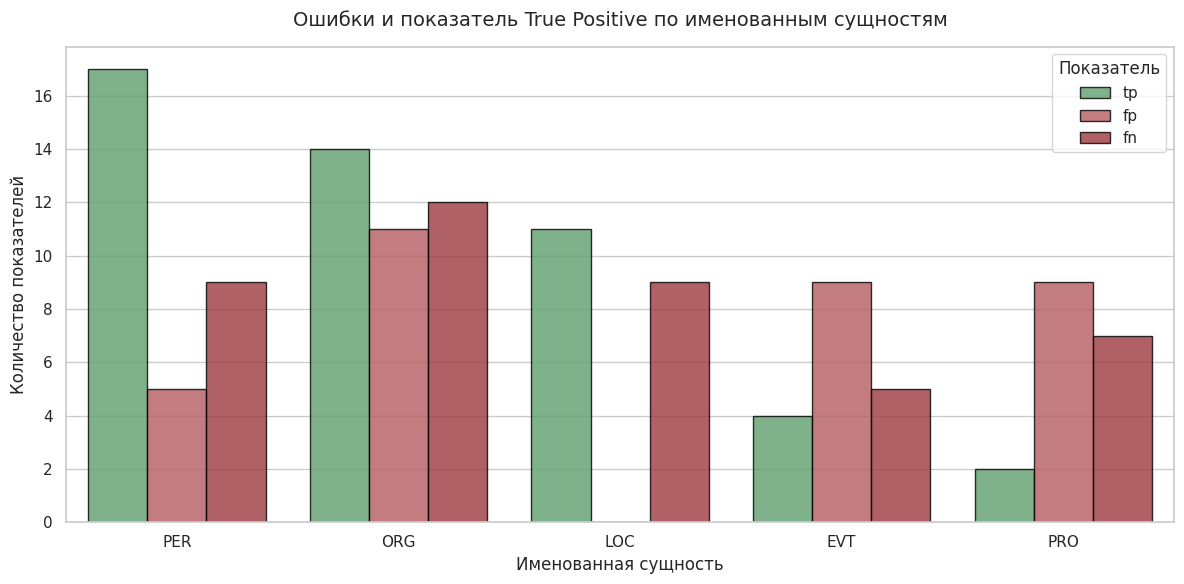

In [339]:
plt.figure(figsize=(12, 6))

sns.barplot(
    data=ne_confusion_df.melt(
        id_vars='named_entity',
        var_name='metric',
        value_name='score'
    ),
    x='named_entity',
    y='score',
    hue='metric',
    palette=['g', 'r', '#ad2831'],
    alpha=0.8,
    edgecolor='black',
    linewidth=1
)

plt.title('Ошибки и показатель True Positive по именованным сущностям', fontsize=14, pad=15)
plt.xlabel('Именованная сущность', fontsize=12)
plt.ylabel('Количество показателей', fontsize=12)

plt.legend(title='Показатель', loc='upper right')
plt.tight_layout()
plt.show()

### Ошибки и показатель True Positive в группировке по документам

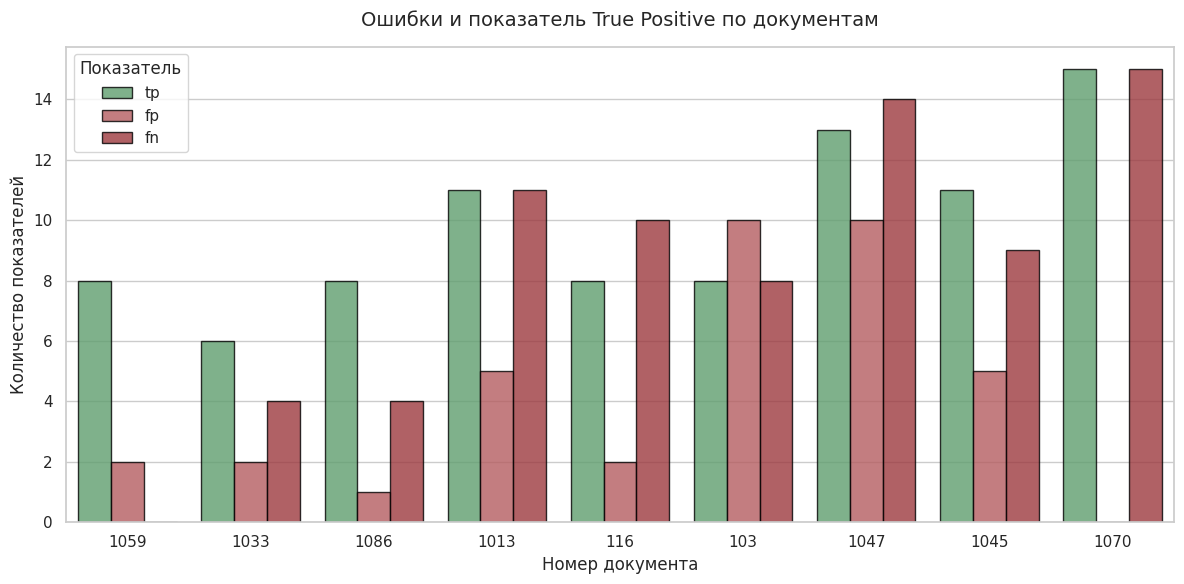

In [348]:
plt.figure(figsize=(12, 6))

sns.barplot(
    data=document_confusion_df.melt(
        id_vars='document_id',
        var_name='metric',
        value_name='score'
    ),
    x='document_id',
    y='score',
    hue='metric',
    palette=['g', 'r', '#ad2831'],
    alpha=0.8,
    edgecolor='black',
    linewidth=1
)

plt.title('Ошибки и показатель True Positive по документам', fontsize=14, pad=15)
plt.xlabel('Номер документа', fontsize=12)
plt.ylabel('Количество показателей', fontsize=12)

plt.legend(title='Показатель', loc='upper left')
plt.tight_layout()
plt.show()

### Общее количество ошибок первого и второго рода и верно размеченных меток 

In [364]:
rates_sums = document_confusion_df[['tp', 'fp', 'fn']].sum()

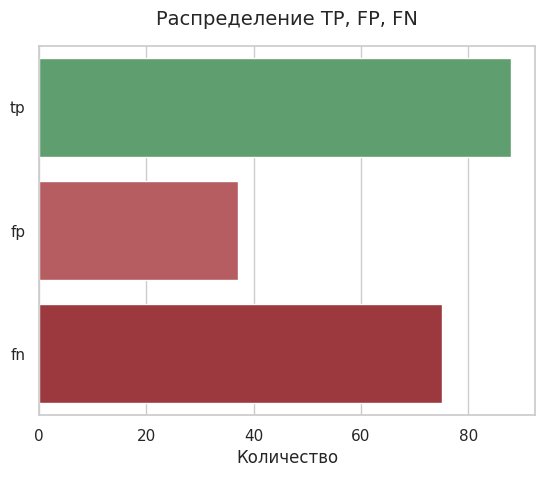

In [366]:
sns.barplot(
    x=rates_sums.values,
    y=rates_sums.index,
    palette=['g', 'r', '#ad2831']
)

plt.xlabel('Количество')
plt.title('Распределение TP, FP, FN', fontsize=14, pad=15)

plt.show()

## Предложения по улучшению метрик

**Предложения из анализа**

1) Как видно по визуализациям чем больше файл, тем хуже в нем соотношение ошибок и верных ответов.\
   Поэтому имеет смысл разделять длинные файлы на части и размечать частами.
2) Преобладает false negative ошибка, это указывает на необходимость более чёткого обучения\
   правилам детекции сущностей.
3) Разметка на определенных сущностях значительно хуже. Чтобы избежать такого, нужно уделить внимение\
   этим сущностям при составлении промпта. Например, проанализировать цепочку размышлений модели,\
   и отследить ошибочные правила, которым следовала модель. Добавить конкретики по данным сущностям\
   в инструкцию.
4) Можно проанализоровать распределение сущностей в файлах и во few-shot добавлять примеры согласно этому\
   распределению.

**Другие предложения**

1) Можно добавить процессу разметки итеративности, отслеживая тяжелые для разметки сущности и поправлять модель.
2) Если цель в снижении стоимости разметки, то оптимально по цене\качеству использовать комбинированную разметку,\
   а не только с помощью LLM, например использовать подход Human in the loop.
3) Так как данный текст с определенным доменом (политические новости), можно импользовать динамический промптинг\
   Добавляя в промпт few-shotы с наиболее схожими к размечаемому тексту примерами. Пример описан в статье\
   от Сбера https://habr.com/ru/companies/sberbank/articles/874062/
5) Разбить задачу извлечения сущности на подзадачи и последовательно решать их с помощью LLM.\
   Можно предварительно с помощью LLM разметить текст BIESO разметкой без разбиения на типы (PER, LOC и другие)\
   и подавать текст с уже выделенными сущностями на определение типа сущности.
   

# Общие выводы из исследования

В данном задании решалась задача извлечения сущностей из документов.\
Были рассмотрены классические подходы. Основной акцент исследования\
сделан на разметке с использованием моделей LLM, в частности GigaChat.

Из датасета, содержащего 178 документов, была сформирована выборка,\
из 9 документов, на которой можно было изучить все аспекты исходной \
выборки. Был собран датасет для разметки.

Затем был разработан промпт, и проведена разметка с использованием веб-интерфейса\
GigaChat. После этого собранные данные были сверены с эталонной разметкой.\
Для проверки качества разметки использовалась функция `score_fn`, которая\
прошла все юнит-тесты, охватывающие все возможные случаи.

Были проанализированы зависимости метрики от длины документов, а также\
проверены метрики по сущностям. Дополнительно был проведен анализ ошибок\
для выявления стратегий улучшения качества разметки.


**Основной вывод:** с помощью GigaChat можно дешево или даже бесплатно\
решать задачу извлечения сущностей. Значение метрик зависит от грамотного\
составления промпта и подачи текста для разметки.

**Благодаря выполнению задания** детальнее узнал подходы к решению задачи NER.\
Посмотрел как извлекают сущности люди из других компаний (спасибо записям митапов и статьям).\
Посмотрел на возможности и особенности GigaChat в разметке, до этого работал с другими LLM.